# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx
!pip install tensorflow==2.3.0 as tf

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

In [3]:
tf.__version__

'2.3.0'

## Initial training

### Load custom modules

In [4]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [5]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Pd_2_classes_linear_comb_new_noise_resnet'
#label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
label_values = ['Pd metal', 'PdO']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder created at /saved_models/20210204_11h49m_Pd_2_classes_linear_comb_new_noise_resnet
Logs folder created at /logs/20210204_11h49m_Pd_2_classes_linear_comb_new_noise_resnet
Figures folder created at /figures/20210204_11h49m_Pd_2_classes_linear_comb_new_noise_resnet


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 381 features (X) + 2 labels (y)


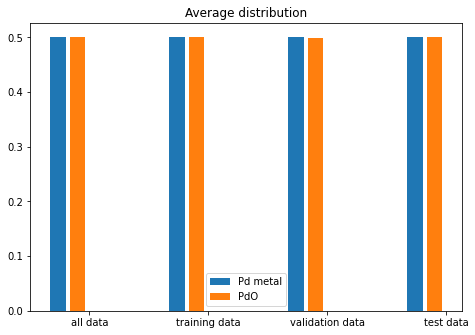

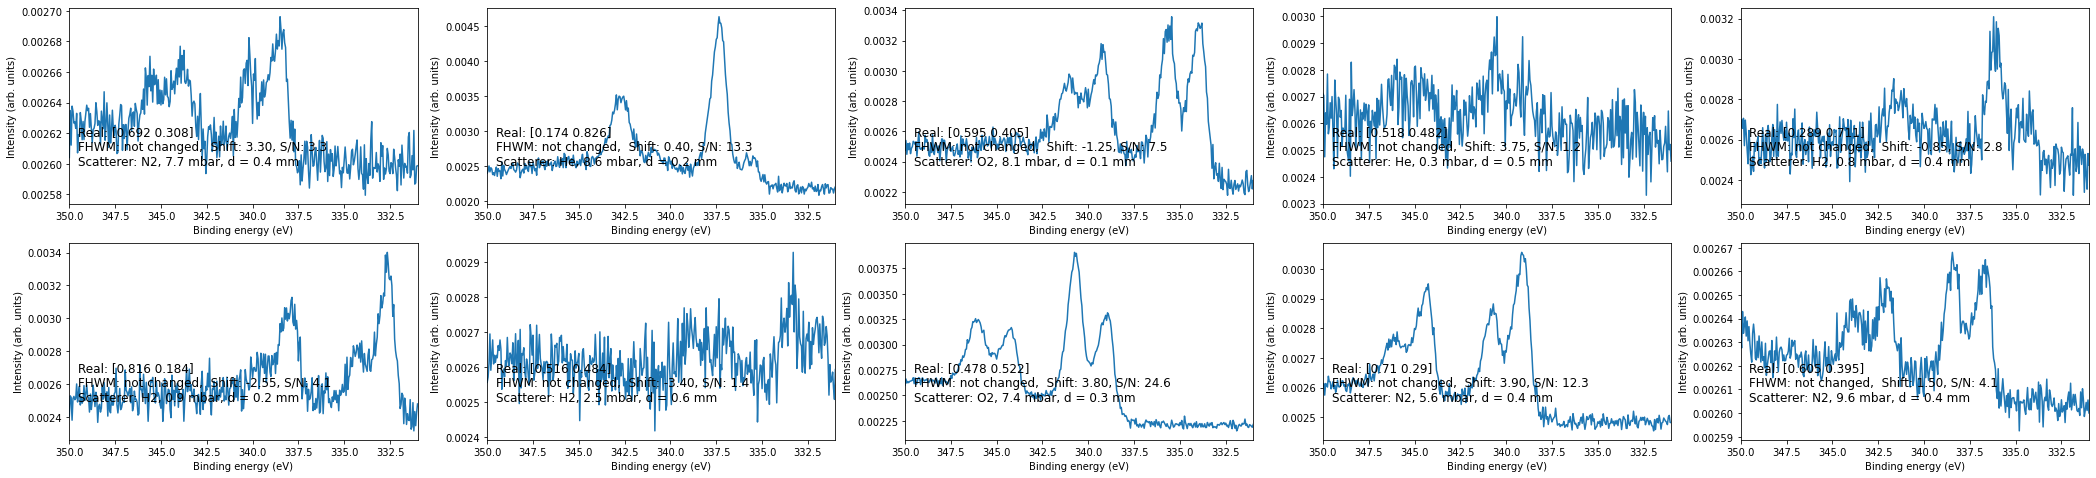

In [6]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210118_palladium_linear_combination_gas_phase.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [7]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Lambda
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras import backend as K

class CustomResNet50(models.EmptyModel):
    def __init__(self, inputshape, num_classes):
      input_1 = Input(shape = inputshape)



      res_net_input = inputshape
      resnet_50 = resnet50.ResNet50(weights = None,
                                    include_top = False,
                                    input_shape = (inputshape[0],
                                                   inputshape[1],
                                                   1))
      resnet_output = resnet_50.output
      global_average_pool_1 = GlobalAveragePooling1D()(resnet_output)
      drop_1 = Dropout(0.7)(global_average_pool_1)
      output = Dense(4000,
                     num_classes, activation= 'sigmoid')(drop_1)

      output = Lambda(lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                      name = 'normalization')(dense_2)
 
      super(CustomResNet50, self).__init__(inputs = resnet_50.input,
                                           outputs = output,
                                           inputshape = inputshape,
                                           num_classes = num_classes,
                                           no_of_inputs = no_of_inputs,
                                           name = 'Custom_ResNet')  
      
class CustomCNNMultiple(models.EmptyModel):
    def __init__(self, inputshape, num_classes):      
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(12, 5, padding = 'same',
                            activation = 'relu')(input_1)
        conv_1_medium = Conv1D(12, 10, padding = 'same',
                             activation = 'relu')(input_1)
        conv_1_long = Conv1D(12, 15, padding = 'same',
                           activation = 'relu')(input_1)
        sublayers = [conv_1_short, conv_1_medium, conv_1_long]
        merged_sublayers = concatenate(sublayers)
        
        conv_2 = Conv1D(10, 5, activation='relu')(merged_sublayers)
        conv_3 = Conv1D(10, 5, activation='relu')(conv_2)
        average_pool_1 = AveragePooling1D()(conv_3)
        
        flatten_1 = Flatten()(average_pool_1)
        drop_1 = Dropout(0.2)(flatten_1)
        dense_1 = Dense(4000, activation = 'relu')(drop_1)
        
        dense_2 = Dense(num_classes, activation = 'sigmoid')(dense_1)
        
        output = Lambda(lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                        name = 'normalization')(dense_2)

        no_of_inputs = len(sublayers)

        super(CustomCNNMultiple, self).__init__(inputs = input_1,
                                                outputs = output,
                                                inputshape = inputshape,
                                                num_classes = num_classes,
                                                no_of_inputs = no_of_inputs,
                                                name = 'Custom_CNN_multiple')

In [ ]:
class CustromResNet50(models.EmptyModel):
    def __init__(self,
                 inputshape,
                 num_classes
                 data_format,
                 name='',
                 include_top=True,
                 pooling=None,
                 block3_strides=False,
                 average_pooling=True,
                 ):
    




class ResNet50(tf.keras.Model):
  """Instantiates the ResNet50 architecture.
  Args:
    data_format: format for the image. Either 'channels_first' or
      'channels_last'.  'channels_first' is typically faster on GPUs while
      'channels_last' is typically faster on CPUs. See
      https://www.tensorflow.org/performance/performance_guide#data_formats
    name: Prefix applied to names of variables created in the model.
    trainable: Is the model trainable? If true, performs backward
        and optimization after call() method.
    include_top: whether to include the fully-connected layer at the top of the
      network.
    pooling: Optional pooling mode for feature extraction when `include_top`
      is `False`.
      - `None` means that the output of the model will be the 4D tensor
          output of the last convolutional layer.
      - `avg` means that global average pooling will be applied to the output of
          the last convolutional layer, and thus the output of the model will be
          a 2D tensor.
      - `max` means that global max pooling will be applied.
    block3_strides: whether to add a stride of 2 to block3 to make it compatible
      with tf.slim ResNet implementation.
    average_pooling: whether to do average pooling of block4 features before
      global pooling.
    classes: optional number of classes to classify images into, only to be
      specified if `include_top` is True.
  Raises:
      ValueError: in case of invalid argument for data_format.
  """

  def __init__(self,
               data_format,
               name='',
               include_top=True,
               pooling=None,
               block3_strides=False,
               average_pooling=True,
               classes=1000):

      valid_channel_values = ('channels_first', 'channels_last')

      def conv_block(filters, stage, block, strides=(2, 2)):
          return _ConvBlock(3,
                            filters,
                            stage=stage,
                      block=block,
                      data_format=data_format,
                      strides=strides)

      def id_block(filters, stage, block):
          return _IdentityBlock(3,
                                filters,
                                stage=stage,
                                block=block,
                                data_format=data_format)
 
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(12, 5, padding = 'same',
                            activation = 'relu')(input_1)

    self.conv1 = layers.Conv2D(
        64, (7, 7),
        strides=(2, 2),
        data_format=data_format,
        padding='same',
        name='conv1')
    bn_axis = 1 if data_format == 'channels_first' else 3
    self.bn_conv1 = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')
    self.max_pool = layers.MaxPooling2D((3, 3),
                                        strides=(2, 2),
                                        data_format=data_format)

    self.l2a = conv_block([64, 64, 256], stage=2, block='a', strides=(1, 1))
    self.l2b = id_block([64, 64, 256], stage=2, block='b')
    self.l2c = id_block([64, 64, 256], stage=2, block='c')

    self.l3a = conv_block([128, 128, 512], stage=3, block='a')
    self.l3b = id_block([128, 128, 512], stage=3, block='b')
    self.l3c = id_block([128, 128, 512], stage=3, block='c')
    self.l3d = id_block([128, 128, 512], stage=3, block='d')

    self.l4a = conv_block([256, 256, 1024], stage=4, block='a')
    self.l4b = id_block([256, 256, 1024], stage=4, block='b')
    self.l4c = id_block([256, 256, 1024], stage=4, block='c')
    self.l4d = id_block([256, 256, 1024], stage=4, block='d')
    self.l4e = id_block([256, 256, 1024], stage=4, block='e')
    self.l4f = id_block([256, 256, 1024], stage=4, block='f')

    # Striding layer that can be used on top of block3 to produce feature maps
    # with the same resolution as the TF-Slim implementation.
    if self.block3_strides:
      self.subsampling_layer = layers.MaxPooling2D((1, 1),
                                                   strides=(2, 2),
                                                   data_format=data_format)
      self.l5a = conv_block([512, 512, 2048],
                            stage=5,
                            block='a',
                            strides=(1, 1))
    else:
      self.l5a = conv_block([512, 512, 2048], stage=5, block='a')
    self.l5b = id_block([512, 512, 2048], stage=5, block='b')
    self.l5c = id_block([512, 512, 2048], stage=5, block='c')

    self.avg_pool = layers.AveragePooling2D((7, 7),
                                            strides=(7, 7),
                                            data_format=data_format)

    if self.include_top:
      self.flatten = layers.Flatten()
      self.fc1000 = layers.Dense(classes, name='fc1000')
    else:
      reduction_indices = [1, 2] if data_format == 'channels_last' else [2, 3]
      reduction_indices = tf.constant(reduction_indices)
      if pooling == 'avg':
        self.global_pooling = functools.partial(
            tf.reduce_mean,
            axis=reduction_indices,
            keepdims=False)
      elif pooling == 'max':
        self.global_pooling = functools.partial(
            tf.reduce_max, reduction_indices=reduction_indices, keep_dims=False)
      else:
        self.global_pooling = None

  def call(self, inputs, training=True, intermediates_dict=None):
    """Call the ResNet50 model.
    Args:
      inputs: Images to compute features for.
      training: Whether model is in training phase.
      intermediates_dict: `None` or dictionary. If not None, accumulate feature
        maps from intermediate blocks into the dictionary.
        ""
    Returns:
      Tensor with featuremap.
    """

    x = self.conv1(inputs)
    x = self.bn_conv1(x, training=training)
    x = tf.nn.relu(x)
    if intermediates_dict is not None:
      intermediates_dict['block0'] = x

    x = self.max_pool(x)
    if intermediates_dict is not None:
      intermediates_dict['block0mp'] = x

    # Block 1 (equivalent to "conv2" in Resnet paper).
    x = self.l2a(x, training=training)
    x = self.l2b(x, training=training)
    x = self.l2c(x, training=training)
    if intermediates_dict is not None:
      intermediates_dict['block1'] = x

    # Block 2 (equivalent to "conv3" in Resnet paper).
    x = self.l3a(x, training=training)
    x = self.l3b(x, training=training)
    x = self.l3c(x, training=training)
    x = self.l3d(x, training=training)
    if intermediates_dict is not None:
      intermediates_dict['block2'] = x

    # Block 3 (equivalent to "conv4" in Resnet paper).
    x = self.l4a(x, training=training)
    x = self.l4b(x, training=training)
    x = self.l4c(x, training=training)
    x = self.l4d(x, training=training)
    x = self.l4e(x, training=training)
    x = self.l4f(x, training=training)

    if self.block3_strides:
      x = self.subsampling_layer(x)
      if intermediates_dict is not None:
        intermediates_dict['block3'] = x
    else:
      if intermediates_dict is not None:
        intermediates_dict['block3'] = x

    x = self.l5a(x, training=training)
    x = self.l5b(x, training=training)
    x = self.l5c(x, training=training)

    if self.average_pooling:
      x = self.avg_pool(x)
      if intermediates_dict is not None:
        intermediates_dict['block4'] = x
    else:
      if intermediates_dict is not None:
        intermediates_dict['block4'] = x

    if self.include_top:
      return self.fc1000(self.flatten(x))
    elif self.global_pooling:
      return self.global_pooling(x)
    else:
      return x



class _ConvBlock(tf.keras.Model):
  """_ConvBlock is the block that has a conv layer at shortcut.
  Args:
      kernel_size: the kernel size of middle conv layer at main path
      filters: list of integers, the filters of 3 conv layer at main path
      stage: integer, current stage label, used for generating layer names
      block: 'a','b'..., current block label, used for generating layer names
      data_format: data_format for the input ('channels_first' or
        'channels_last').
      strides: strides for the convolution. Note that from stage 3, the first
       conv layer at main path is with strides=(2,2), and the shortcut should
       have strides=(2,2) as well.
  """

  def __init__(self,
               kernel_size,
               filters,
               stage,
               block,
               data_format,
               strides=(2, 2)):
    super(_ConvBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    bn_axis = 1 if data_format == 'channels_first' else 3

    self.conv2a = layers.Conv2D(
        filters1, (1, 1),
        strides=strides,
        name=conv_name_base + '2a',
        data_format=data_format)
    self.bn2a = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '2a')

    self.conv2b = layers.Conv2D(
        filters2,
        kernel_size,
        padding='same',
        name=conv_name_base + '2b',
        data_format=data_format)
    self.bn2b = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '2b')

    self.conv2c = layers.Conv2D(
        filters3, (1, 1), name=conv_name_base + '2c', data_format=data_format)
    self.bn2c = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '2c')

    self.conv_shortcut = layers.Conv2D(
        filters3, (1, 1),
        strides=strides,
        name=conv_name_base + '1',
        data_format=data_format)
    self.bn_shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    shortcut = self.conv_shortcut(input_tensor)
    shortcut = self.bn_shortcut(shortcut, training=training)

    x += shortcut
    return tf.nn.relu(x)

### Build the model

In [24]:
clf.model = CustomResNet50(clf.input_shape, clf.num_classes)
#clf.model = CustomCNNMultiple(clf.input_shape, clf.num_classes)

# Alternative: Build model from available models
#clf.model = models.CustomCNNMultiple(clf.input_shape, clf.num_classes)

ValueError: ignored

### Compile and summarize the model

Model: "Custom_CNN_multiple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 381, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 381, 12)      72          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 381, 12)      132         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 381, 12)      192         input_1[0][0]                    
________________________________________________________________________________

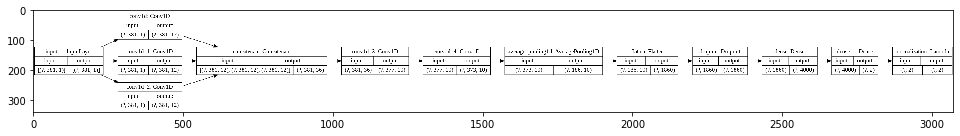

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()

# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print(y_train[:5])
print(pred_train_initial[:5])

print(y_test[:5])
print(pred_test_initial[:5])

7/7 [==============================] - 0s 25ms/step
Prediction done!
[[0.73111472 0.26888528]
 [0.27848006 0.72151994]
 [0.82202801 0.17797199]
 [0.18471778 0.81528222]
 [0.19827042 0.80172958]]
[[0.49999878 0.50000125]
 [0.49998698 0.50001305]
 [0.499987   0.500013  ]
 [0.5000072  0.4999928 ]
 [0.49998033 0.50001967]]
[[0.65320806 0.34679194]
 [0.59188603 0.40811397]
 [0.48442233 0.51557767]
 [0.46672564 0.53327436]
 [0.31401283 0.68598717]]
[[0.49998778 0.5000122 ]
 [0.49998683 0.5000132 ]
 [0.50001943 0.4999806 ]
 [0.49998778 0.5000122 ]
 [0.49998558 0.5000144 ]]


### Train

In [ ]:
epochs = 1000
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/1000
2000/2000 [==============================] - 214s 107ms/step - loss: 0.1481 - val_loss: 0.1466
Epoch 2/1000
2000/2000 [==============================] - 219s 110ms/step - loss: 0.1481 - val_loss: 0.1466
Epoch 3/1000
2000/2000 [==============================] - 223s 111ms/step - loss: 0.1480 - val_loss: 0.1464
Epoch 4/1000
2000/2000 [==============================] - 222s 111ms/step - loss: 0.1475 - val_loss: 0.1457
Epoch 5/1000
2000/2000 [==============================] - 223s 111ms/step - loss: 0.1467 - val_loss: 0.1446
Epoch 6/1000
2000/2000 [==============================] - 219s 110ms/step - loss: 0.1457 - val_loss: 0.1436
Epoch 7/1000
2000/2000 [==============================] - 220s 110ms/step - loss: 0.1449 - val_loss: 0.1429
Epoch 8/1000
2000/2000 [==============================] - 216s 108ms/step - loss: 0.1440 - val_loss: 0.1425
Epoch 9/1000
2000/2000 [==============================] - 217s 108ms/step - loss: 0.1429 - val_loss: 0.1406
Epoch 10/1000
2000/2000 [===

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Set up the parameters & folder structure

In [ ]:
np.random.seed(502)
time = '20210120_20h36m'
data_name = 'Pd_2_classes_linear_comb_new_noise'

#label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
label_values = ['Pd metal', 'PdO']
clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder was already at /saved_models/20210120_20h36m_Pd_2_classes_linear_comb_new_noise
Logs folder was already at /logs/20210120_20h36m_Pd_2_classes_linear_comb_new_noise
Figures folder was already at /figures/20210120_20h36m_Pd_2_classes_linear_comb_new_noise


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 381 features (X) + 2 labels (y)


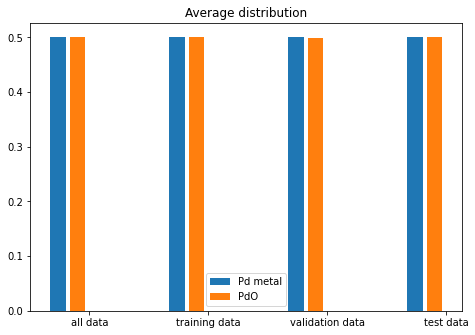

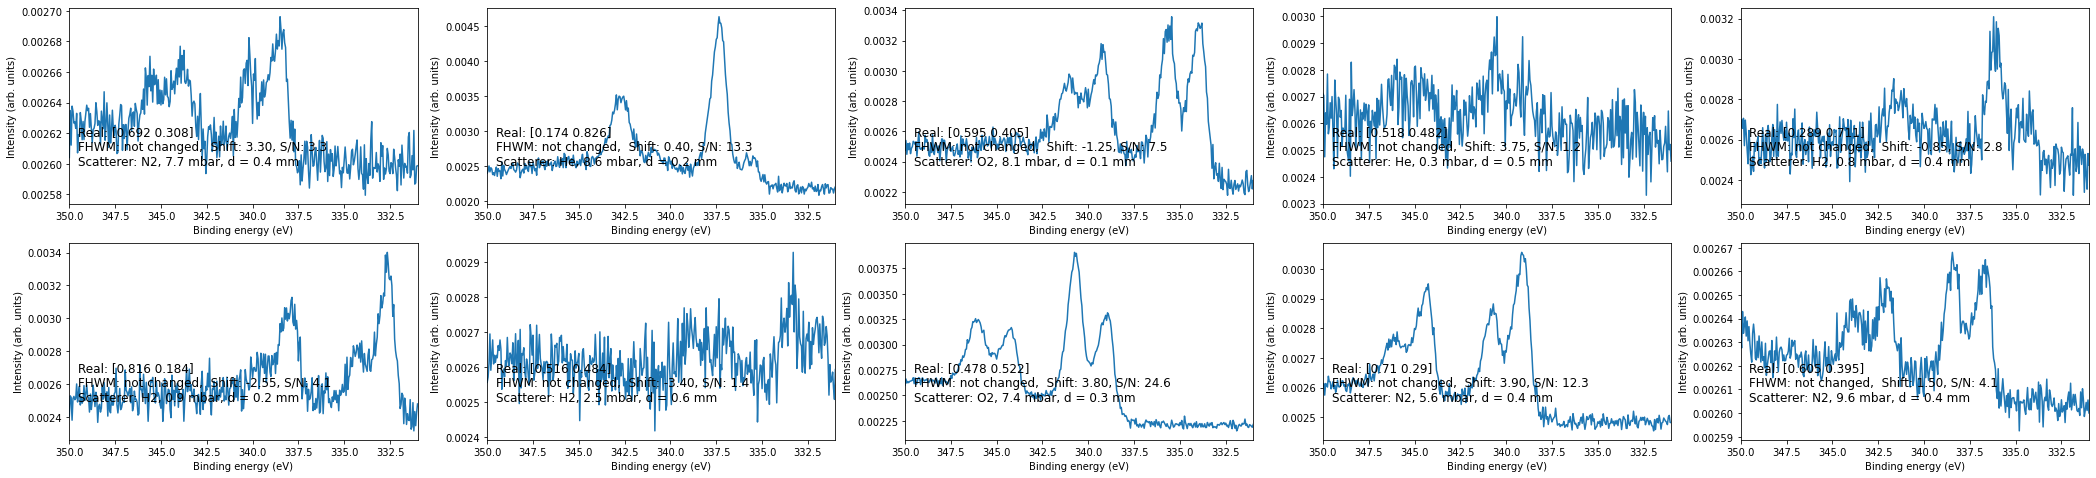

In [ ]:
input_filepath = r'/content/drive/My Drive/app/datasets/20210118_palladium_linear_combination_gas_phase.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
                
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
clf.load_model()

Loaded model from disk.


### Compile and summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 381, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 381, 12)      72          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 381, 12)      132         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 381, 12)      192         input_1[0][0]                    
_______________________________________________________________________________________

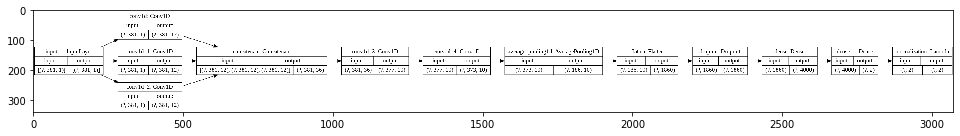

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()
# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Train

In [ ]:
epochs = 200
batch_size = 32

# =============================================================================
# hist = clf.train(checkpoint = True,
#                  early_stopping = False,
#                  tb_log = True, 
#                  csv_log = True,
#                  epochs = epochs, 
#                  batch_size = batch_size,
#                  verbose = 1)
# =============================================================================

new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)#, 
#                 new_learning_rate = new_learning_rate)

Epoch 384/583
2000/2000 [==============================] - 218s 109ms/step - loss: 0.0187 - val_loss: 0.0161
Epoch 385/583
2000/2000 [==============================] - 221s 110ms/step - loss: 0.0189 - val_loss: 0.0157
Epoch 386/583
2000/2000 [==============================] - 218s 109ms/step - loss: 0.0187 - val_loss: 0.0157
Epoch 387/583
2000/2000 [==============================] - 221s 111ms/step - loss: 0.0189 - val_loss: 0.0139
Epoch 388/583
2000/2000 [==============================] - 219s 109ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 389/583
2000/2000 [==============================] - 218s 109ms/step - loss: 0.0187 - val_loss: 0.0150
Epoch 390/583
2000/2000 [==============================] - 219s 109ms/step - loss: 0.0187 - val_loss: 0.0143
Epoch 391/583
2000/2000 [==============================] - 219s 109ms/step - loss: 0.0187 - val_loss: 0.0163
Epoch 392/583
2000/2000 [==============================] - 218s 109ms/step - loss: 0.0185 - val_loss: 0.0146
Epoch 393/583
2000/

In [ ]:
from tensorflow.keras import backend as K
print('New learning rate: ' +\
      str(K.eval(clf.model.optimizer.lr)))

### Plot loss

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()

### Evaluate on test data

In [ ]:
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train & test data

In [ ]:
pred_train, pred_test = clf.predict()

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show worst predictions

In [ ]:
clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'train_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')